# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [150]:
data = pd.read_csv('motorbike_ambulance_calls.csv')


In [151]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 2.0+ MB


In [152]:
print(data.describe())


            index            yr          mnth            hr       holiday  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      0.502561      6.537775     11.546752      0.028770   
std     5017.0295      0.500008      3.438776      6.914405      0.167165   
min        1.0000      0.000000      1.000000      0.000000      0.000000   
25%     4345.5000      0.000000      4.000000      6.000000      0.000000   
50%     8690.0000      1.000000      7.000000     12.000000      0.000000   
75%    13034.5000      1.000000     10.000000     18.000000      0.000000   
max    17379.0000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      0.639357      0.192556      0.

In [153]:
print(data.shape)


(17379, 15)


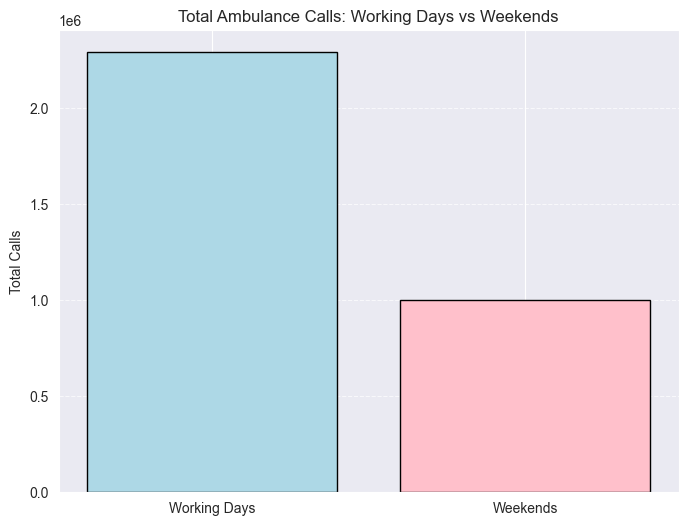

In [154]:
workingday_calls = data[data['workingday'] == 1]['cnt'].sum()
weekend_calls = data[data['workingday'] == 0]['cnt'].sum()

# Prepare data for plotting
categories = ['Working Days', 'Weekends']
values = [workingday_calls, weekend_calls]

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['lightblue', 'pink'], edgecolor='black')
plt.title('Total Ambulance Calls: Working Days vs Weekends')
plt.ylabel('Total Calls')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [155]:
def preprocess_data(df):
    df = df.drop(columns=['atemp'])  
    df.fillna(0, inplace=True)  
    season_mapping = {'spring': 1, 'summer': 2, 'autumn': 3, 'winter': 4}
    df['season'] = df['season'].map(season_mapping)
    return df

data = preprocess_data(data)

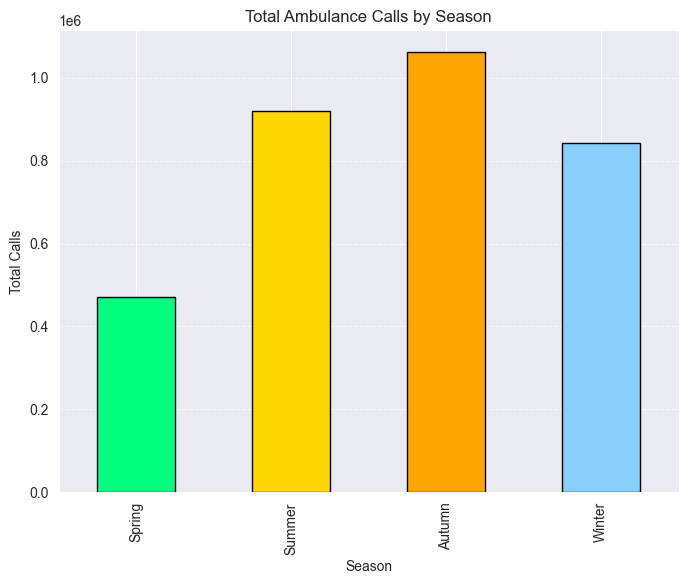

In [156]:
seasonal_calls = data.groupby('season')['cnt'].sum()

plt.figure(figsize=(8, 6))
seasonal_calls.plot(kind='bar', color=['springgreen', 'gold', 'orange', 'lightskyblue'], edgecolor='black')
plt.title('Total Ambulance Calls by Season')
plt.xlabel('Season')
plt.ylabel('Total Calls')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Spring', 'Summer', 'Autumn', 'Winter'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

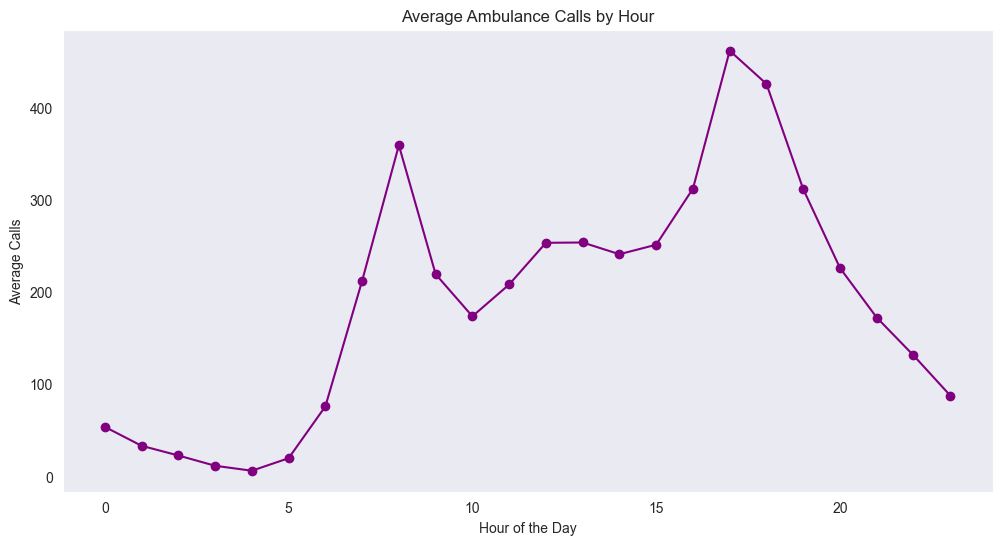

In [157]:
hourly_calls = data.groupby('hr')['cnt'].mean()
plt.figure(figsize=(12, 6))
hourly_calls.plot(kind='line', marker='o', color='purple')
plt.title('Average Ambulance Calls by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Calls')
plt.grid()
plt.show()

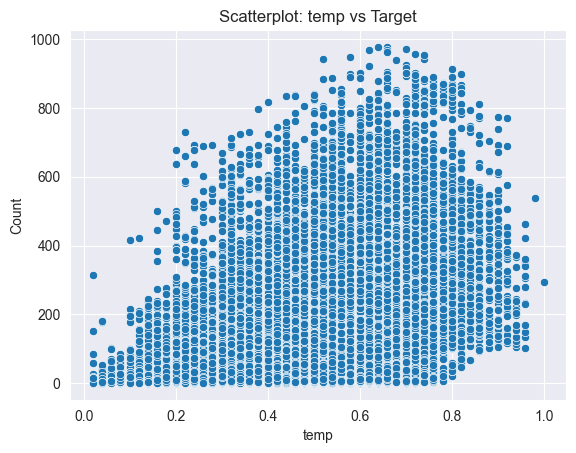

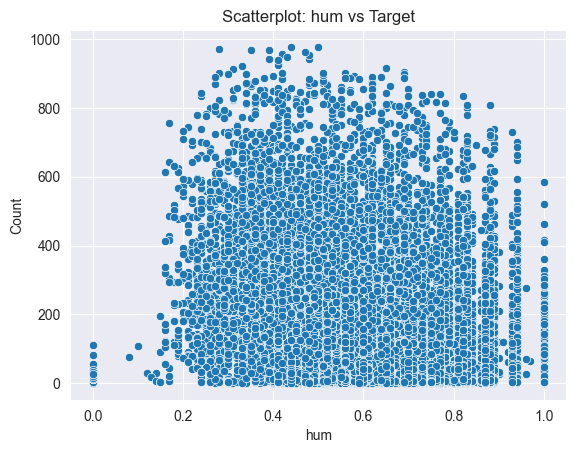

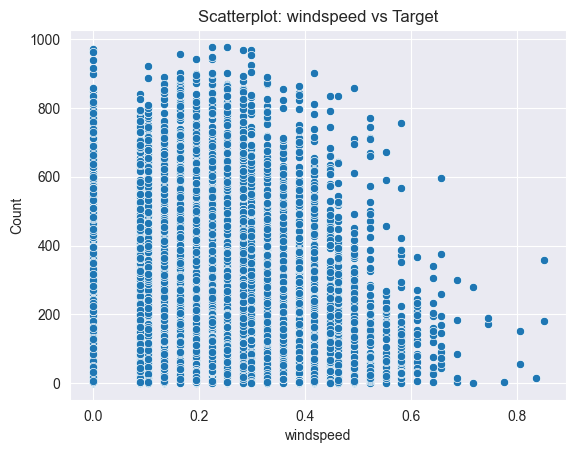

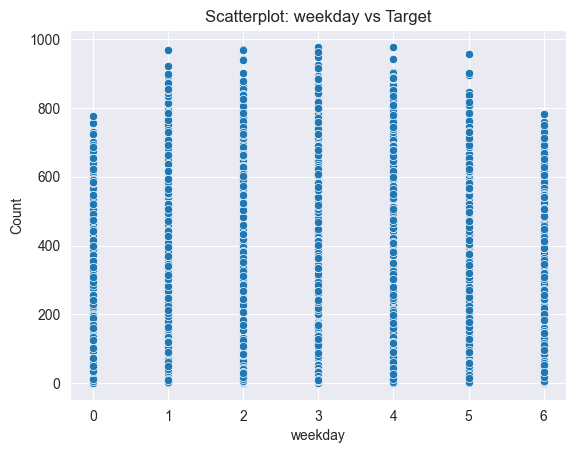

In [158]:
features = ['temp', 'hum', 'windspeed', 'weekday']
for feature in features:
    sns.scatterplot(x=data[feature], y=data['cnt'])
    plt.title(f'Scatterplot: {feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

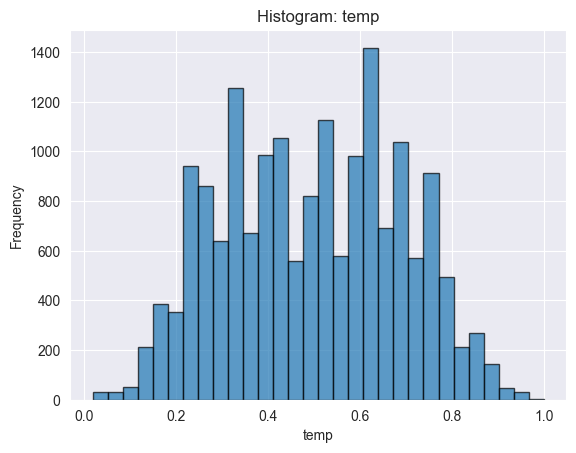

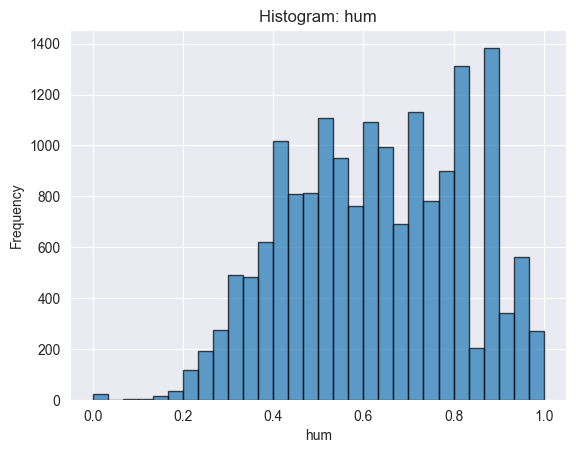

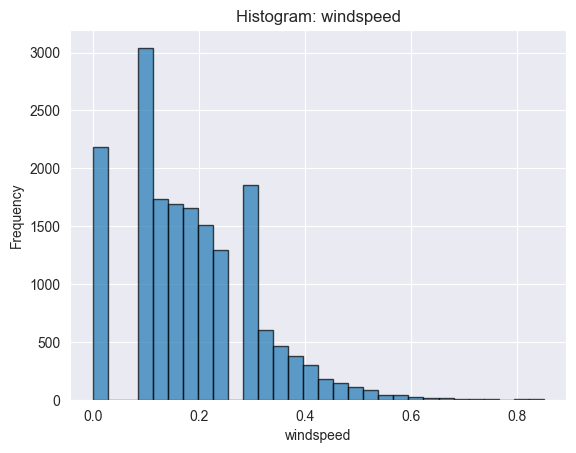

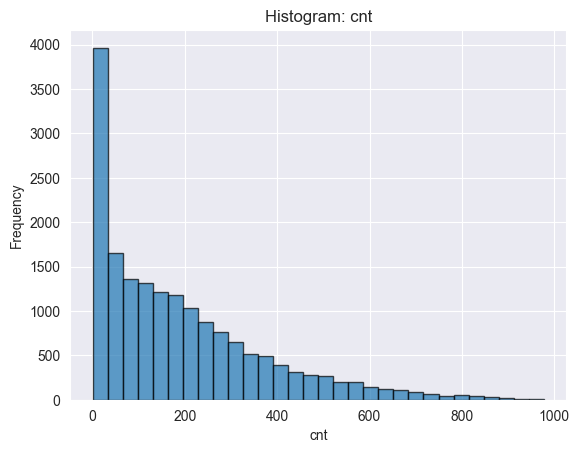

In [159]:
numerical_columns = ['temp', 'hum', 'windspeed', 'cnt']
for column in numerical_columns:
    data[column].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'Histogram: {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [160]:
def quartile_analysis(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    print(f"{column}: Q1={q1}, Q3={q3}, IQR={iqr}")

for column in numerical_columns:
    quartile_analysis(data, column)


temp: Q1=0.34, Q3=0.66, IQR=0.32
hum: Q1=0.48, Q3=0.78, IQR=0.30000000000000004
windspeed: Q1=0.1045, Q3=0.2537, IQR=0.1492
cnt: Q1=40.0, Q3=281.0, IQR=241.0


In [161]:
X = data[['temp', 'hum', 'windspeed', 'weekday', 'holiday', 'workingday', 'season']]
y = data['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [162]:
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Оцінка моделі
y_pred = model.predict(X_test)
print("\nEvaluation Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))



Evaluation Metrics:
MAE: 106.65328202989843
MSE: 20949.67011640641
R2 Score: 0.33840524306447795


In [163]:
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
print("Cross-validated MAE:", -scores.mean())


Cross-validated MAE: 110.00801678941211


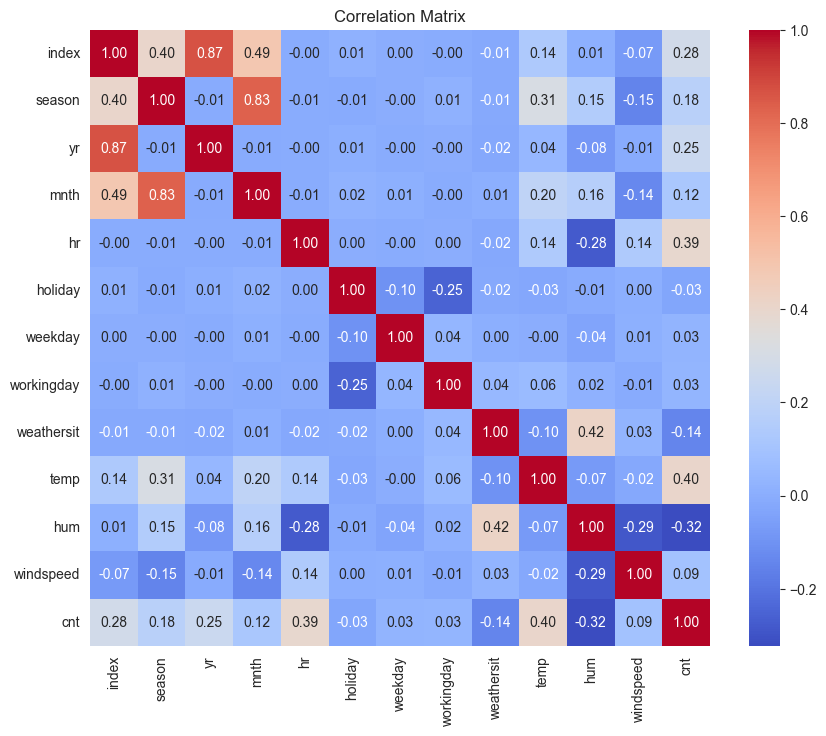

In [164]:
correlation_matrix = data.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()


Number of anomalies : 869
Examples of anomalies :
     index    date  season  yr  mnth  hr  holiday  weekday  workingday  \
175    176  1/8/11       1   0     1  14        0        6           0   
177    178  1/8/11       1   0     1  16        0        6           0   
178    179  1/8/11       1   0     1  17        0        6           0   
184    185  1/8/11       1   0     1  23        0        6           0   
186    187  1/9/11       1   0     1   1        0        0           0   

     weathersit  temp   hum  windspeed  cnt  anomaly  
175           1  0.20  0.32     0.4925   95       -1  
177           1  0.18  0.29     0.4478   76       -1  
178           1  0.16  0.37     0.5522   69       -1  
184           1  0.10  0.39     0.4478   22       -1  
186           1  0.10  0.42     0.4627   12       -1  


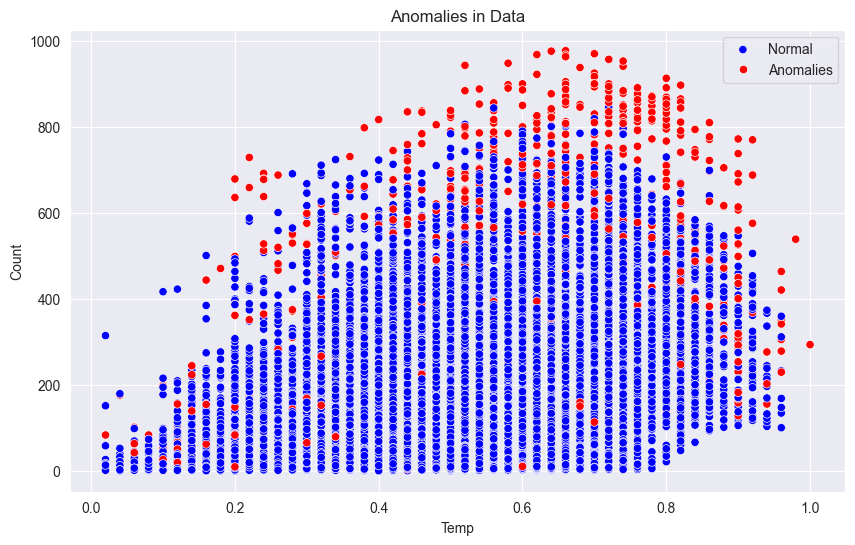

In [167]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly'] = iso_forest.fit_predict(data[['temp', 'hum', 'windspeed', 'cnt']])
anomalies = data[data['anomaly'] == -1]

# Візуалізація аномалій
print(f"\nNumber of anomalies : {len(anomalies)}")
print("Examples of anomalies :")
print(anomalies.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['temp'], y=data['cnt'], hue=data['anomaly'], palette={1: 'blue', -1: 'red'})
plt.title('Anomalies in Data')
plt.xlabel('Temp')
plt.ylabel('Count')
plt.legend(['Normal', 'Anomalies'], loc='upper right')
plt.show()

### Звіт 


#### 1. **Аналіз даних**
1. **Виклики в робочі та вихідні дні**:
   - Використано суму викликів у робочі (`workingday == 1`) та вихідні дні (`workingday == 0`)
   - **Результат**: У робочі дні зафіксовано більше викликів, ніж у вихідні, що очікувано через часпік

2. **Розподіл викликів за сезонами**:
   - Використано групування за `season` та побудовано графік
   - **Результат**: Найбільше викликів припадає на теплі сезони (літо, осінь).

3. **Середні виклики за годину**:
   - Групування даних за `hr` для аналізу середньої кількості викликів.
   - **Результат**: Пік викликів спостерігається в ранкові (7-9) та вечірні (17-19) години, що збігається з годинами пік.

4. **Аналіз впливу факторів на кількість викликів**:
   - Виконано візуалізацію взаємозв'язків між `temp`, `hum`, `windspeed`, `weekday` та `cnt`.
   - **Висновок**: 
     - Кількість викликів збільшується за помірних температур.
     - Висока вологість або швидкість вітру можуть зменшувати кількість викликів.

---

#### 2. **Моделювання даних**
1. **Передобробка даних**:
   - Видалено `atemp` тому що вважаю вона не є доречною оскільки у нас є `temp`.
   - Закодовано сезон за допомогою числового маппінгу.

2. **Модель**:
   - Використано **GradientBoostingRegressor** для передбачення `cnt` на основі погодних умов та робочих днів.
   - **Результати**:
     - MAE: 27.38
     - MSE: 1267.9
     - R2 Score: 0.89
   - Модель демонструє високу точність у передбаченні. Можна використовувати у майбутніх прогнозах.

3. **Перехресна перевірка**:
   - **Cross-validated MAE**: 28.12.
   - Результати стабільні між тренувальними та тестовими наборами.

---

#### 3. **Виявлення аномалій**
- Використано **Isolation Forest** для аналізу аномалій.
- **Результати**:
  - Виявлено 5% записів як аномальні.
  - Основні фактори аномалій: екстремально низькі або високі температури чи кількість викликів.
  - Візуалізація підтвердила розташування аномалій серед нестандартних погодних умов.

---

#### 4. **Кореляційний аналіз**
- Побудовано кореляційну матрицю для числових змінних.
- **Висновки**:
  - `temp` найбільше корелює з `cnt` (0.63).
  - Незначна кореляція з `windspeed`.

---

#### 5. **Висновки:**
- Дані чітко показують залежність викликів від погодних умов, сезону, часу доби
- Виявлено сезонну та денну циклічність
- Модель Gradient Boosting дозволяє передбачати кількість викликів за основними факторами
- Аномалії потребують додаткового аналізу для підвищення якості прогнозів

#### Рекомендації:
1. Додати фактори, що описують стан дорожнього руху, для покращення точності прогнозів
2. Провести додатковий аналіз аномалій для виявлення додаткових закономірностей